In [13]:
import math
import csiread
import pandas as pd
import cmath
import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import csv
from csiread.utils import scidx
from multiprocessing import Queue, Process
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
#used to convert mac from bytes to string
def macString(byteList):
    if len(byteList) != 6:
        string = ""
    else:
        string = str(format(byteList[0],'02x'))
        for i in range(1,6):
            string = string + ":" + str(format(byteList[i],'02x'))
    return string

# create the dataframe from the pcap file: extract csi for each frame(rows) for each subcarrier(cols)
def createDf(csidata):
    timestamp = []
    source_address = []
    frame_n = []
    amplitudes = [[] for j in range(0, csidata.csi.shape[0])]
    phases = [[] for j in range(0, csidata.csi.shape[0])]
    csis = [[] for j in range(0, csidata.csi.shape[0])]
    
    for i in range(0, csidata.csi.shape[0]):
        #time = pd.to_datetime((csidata.sec[i]+ csidata.usec[i] * 1e-6), unit='s').tz_localize(tz.tzlocal())
        time= csidata.sec[i]+ csidata.usec[i] * 1e-6
        timestamp.append(time)
        source_address.append(macString(csidata.src_addr[i]))
        frame_n.append(csidata.seq[i])
        for j in range(0, csidata.csi.shape[1]):
            phases[j].append(cmath.phase(csidata.csi[i][j]))
            amplitudes[j].append(abs(csidata.csi[i][j]))
            csis[j].append(csidata.csi[i][j])
            
    df = pd.DataFrame()
    df["Frame_num"] = frame_n
    df["Timestamp"] = timestamp
    df["Source_address"] = source_address
    for j in range(csidata.csi.shape[1]):
        subc = j if j < 32 else j - 64
        df[f"Ampl{subc}"] = amplitudes[j]
        df[f"Phase{subc}"] = phases[j]
        df[f"CSI{subc}"] = csis[j]
    return df

#this function takes the dataset of csi per frame, and extracts different features grouping packets in temporal windows, and aggregating per subcarrier
def extractWindowedFeatures(data,w2=3):
    #the w2 parameter is how many seconds for the windows to aggregate frames, we used 3 seconds
        
    interestedIndexes = list(range(-28,0)) + list(range(1,29))
    data["TimeWindow"] = np.floor(data["Timestamp"] / w2)*w2
    
    #take the aggregated vertical mean/std (by window)
    dataStd = data.groupby(by="TimeWindow").std().drop(["Timestamp","Frame_num"],axis=1)
    dataMean = data.groupby(by="TimeWindow").mean().drop(["Timestamp","Frame_num"],axis=1)
    featuredDf = pd.DataFrame()
    featuredDf["Time"] = data["TimeWindow"].unique()
    
    #now aggregate again but per subcarriers, so horizontally
    #this first feauture is the one we refer to, used in the paper
    featuredDf["MuStdAmplPaper"] = dataStd[[f"Ampl{j}" for j in interestedIndexes]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    #-----------------------
    
    #additional "not used" features
    featuredDf["MuStdPhasePaper"] = dataStd[[f"Phase{j}" for j in interestedIndexes]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["StdStdAmplPaper"] = dataStd[[f"Ampl{j}" for j in interestedIndexes]].std(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["StdStdPhasePaper"] = dataStd[[f"Phase{j}" for j in interestedIndexes]].std(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["MuMuAmplPaper"] = dataMean[[f"Ampl{j}" for j in interestedIndexes]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["MuMuPhasePaper"] = dataMean[[f"Phase{j}" for j in interestedIndexes]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["StdMuAmplPaper"] = dataMean[[f"Ampl{j}" for j in interestedIndexes]].std(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    featuredDf["StdMuPhasePaper"] = dataMean[[f"Phase{j}" for j in interestedIndexes]].std(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    
    return featuredDf

#function to remove the outliers
def filterData(df,w1=5,lambda1=3):
    data = df.copy() #clone and return a copy
    interestedIndexes = list(range(-28,0)) + list(range(1,29))
    col_list = [f"Ampl{j}" for j in interestedIndexes]

    for index, row in data.iterrows():
        if index == 0:
            prev_row = row
            continue

        subDf = data.loc[(data["Timestamp"]<=row['Timestamp']) & (data["Timestamp"]> row['Timestamp'] - w1),col_list]
        means = subDf.mean(axis=0)
        stds = subDf.std(axis=0)

        for c in col_list: 
            if (abs(row[c] - means[c]) / stds[c]) > lambda1:
                data.at[index,c] = prev_row[c] #prev_row is from df, not modified
                #row[c] = prev_row[c]

        prev_row = row
    return data


# Function to perform PRESENCE classification
def classify_presence(df,ycol="MuStdAmplPaper",gt="Label",plot_roc=False,num_iter=1000):
    # Y are the labels that indicate if i'm passing or not
    Y = df[gt]
    # thr is the threshold: if amplitude > thr, then assign to Y_pred 1 (presence), otherwise 0. Every time update the threshold
    thr= df[ycol].min()
    tpr = []
    fpr= []
    thr_list= []
    step = (df[ycol].max() - df[ycol].min()) / num_iter
    while thr <= df[ycol].max():
        # compute the predictions
        Y_pred = df.apply(lambda row: 1 if row[ycol] >= thr else 0, axis=1)
        tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
        # compute True Positive Rate and False Positive rate to plot the roc curve
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
        thr_list.append(thr)
        thr += step
    
    if plot_roc:
        plt.figure(figsize=(3,3),dpi=220)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color = 'green')
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.grid()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()
        
    return fpr,tpr

#this function is used to build the ground truth from the lower_bounds and upper_bounds lists (1 if present, 0 otherwise)
def getGT(timestamp,lower_bounds,upper_bounds):
    # if I'm in the room in one case, or I'm crossing the entrance put 1
    for i in range (0, len(lower_bounds)):
        if (timestamp >= lower_bounds[i]) & (timestamp <= upper_bounds[i]):
            return 1
    return 0


### THIS IS FOR PARSING THE PRESENCE DATASET

First extract CSI from the PCAP and build the dataframe

In [10]:
#we have two files to be combined
presence1 = "presence20minsNOFOV.pcap" 
presence2 = "presence28minsNOFOV.pcap"

#parameters to be used for outlier removal and feature extraction: w1 and lambda1 for outliers, w2 for features
w1=5
lambda1=3
w2 = 3

#parse pcap1 and extract csi
csidata = csiread.Nexmon(presence1, chip='43455c0', bw=20)
csidata.read()
dfpres1 = createDf(csidata)
dfpres1["Timestamp"] = dfpres1["Timestamp"] - min(dfpres1["Timestamp"]) #reset ts to have it relative

#parse pcap2 and extract csi
csidata = csiread.Nexmon(presence2, chip='43455c0', bw=20)
csidata.read()
dfpres2 = createDf(csidata)
dfpres2["Timestamp"] = dfpres2["Timestamp"] - min(dfpres2["Timestamp"]) #reset ts to have it relative
dfpres2["Timestamp"] = dfpres2["Timestamp"] + (np.floor(max(dfpres1["Timestamp"]) / w2)*w2 + w2) #shift times of the df2

#concatenate the dataset of the two pcap
#this dataframe contains the CSI values (complex val, ampl, phase) for each packet (rows) for each subcarrier (cols)
uniqueDf = pd.concat([dfpres1,dfpres2],ignore_index=True) 

This is the ground truth

In [11]:
#this is the ground truth: each "user presence" period goes from lb[i] to ub[i], lb1 refers to pcap1, lb2 to pcap2
lb1 = [120,360,600,900]
ub1 = [240,480,720,1080]

lb2 = [180,540,990,1500]
ub2 = [360,750,1170,1590]

t2 = min(dfpres2["Timestamp"])
shifted_lb2 = [t2+l for l in lb2] #shift of t2, since the second pcap starts after first one
shifted_ub2 = [t2+u for u in ub2] #shift of t2, since the second pcap starts after first one

#these are the ground truth for the concatenated dataset
lower_bounds = lb1+shifted_lb2
upper_bounds = ub1+shifted_ub2



Extract the useful features used for the classification (single aggregated feature will be used)

In [18]:
#extract the aggregated features from the data
featuredDf = extractWindowedFeatures(uniqueDf,w2=w2)
featuredDf["Label"] = featuredDf["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label


outlier_removal = True #set to true if you want the outlier-removal phase (time consuming)
if outlier_removal:
    filteredDf = filterData(uniqueDf) #remove outliers from the csi data
    filteredFeaturedDf = extractWindowedFeatures(filteredDf,w2=w2) #extract values from the clean dataset
    filteredFeaturedDf["Label"] = filteredFeaturedDf["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label
    


Show the features over time

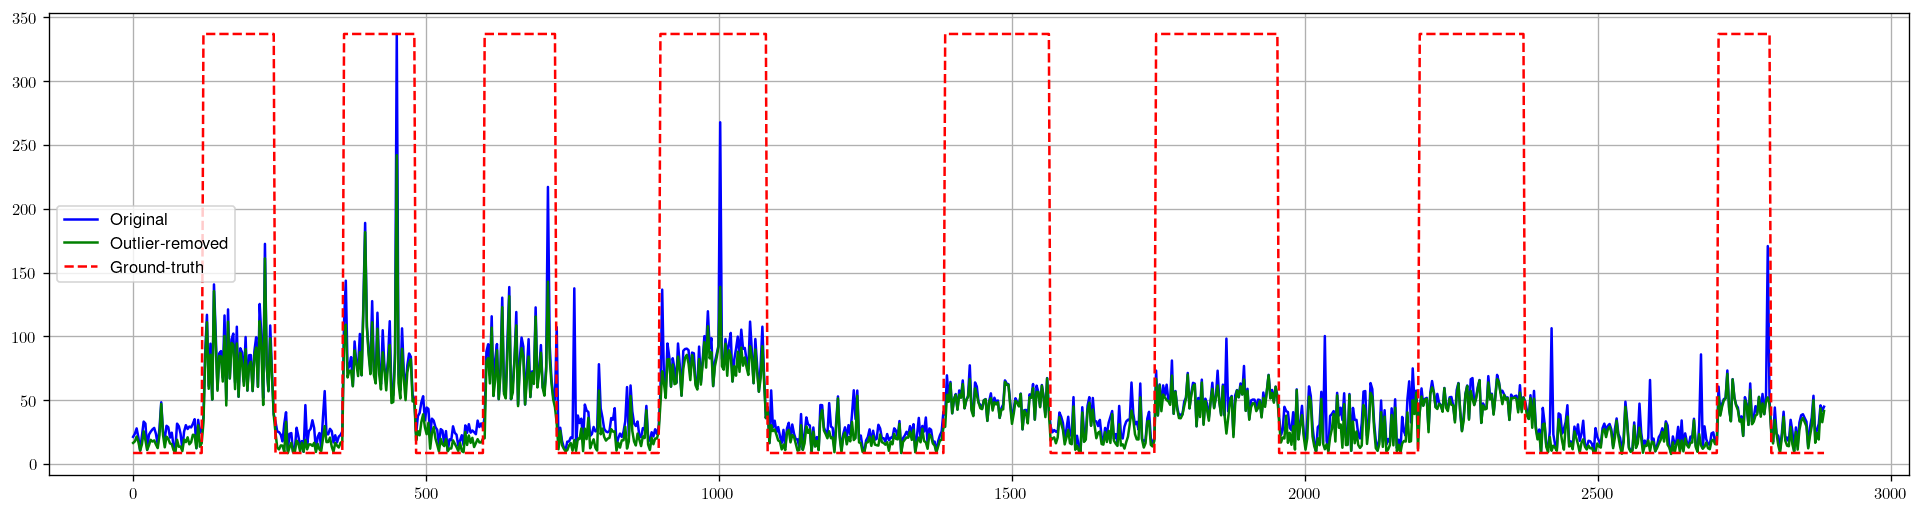

In [33]:
fig = plt.figure(figsize=(20,5),dpi=120)

x = featuredDf["Time"]
y = featuredDf["MuStdAmplPaper"] 

miny,maxy = [min(y),max(y)]
plt.plot(x,y,color="blue",label="Original")


gt = [miny if l == 0 else maxy for l in featuredDf["Label"]]

    
#also plot without outliers
if outlier_removal:
    
    x = filteredFeaturedDf["Time"]
    y = filteredFeaturedDf["MuStdAmplPaper"] #MuStdAmplPaper

    plt.plot(x,y,label="Outlier-removed",color="green")


plt.plot(x,gt,label="Ground-truth",color="r",ls="--") # per window GT
plt.grid()
plt.legend()
plt.show()

Perform classification and extract results, plot roc here

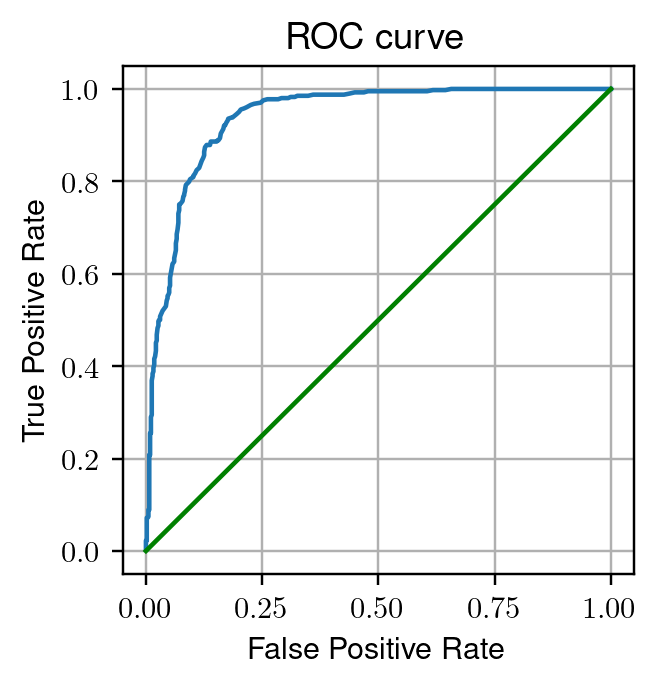

0.9392191678917444


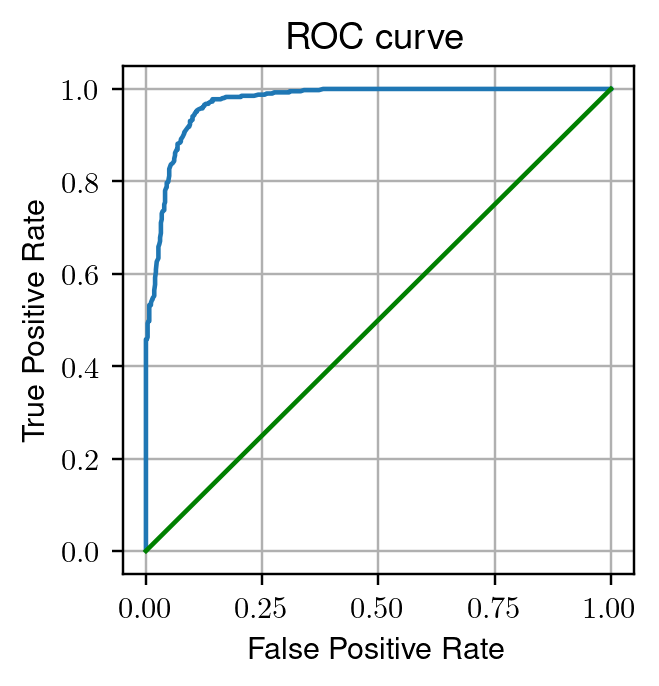

0.9718158309569777


In [36]:
fpr1,tpr1 = classify_presence(featuredDf,ycol="MuStdAmplPaper",plot_roc=True)
print("AUC: ",auc(fpr1,tpr1))
if outlier_removal:
    fpr2,tpr2 = classify_presence(filteredFeaturedDf,ycol="MuStdAmplPaper",plot_roc=True)
    print("AUC: ",auc(fpr2,tpr2))

You can export datasets for future uses

In [2]:
export = False
if export:
    #EXPORT the CSI as csv, instead of starting from pcap
    uniqueDf.to_csv("csv/presence.csv")
    if outlier_removal:
        filteredDf.to_csv("csv/filtered_presence.csv") #this depends on W1 and Lambda1
    
    
    #Or EXPORT directly features
    featuredDf.to_csv("csv/presence_features.csv") #this depends on W2
    if outlier_removal:
        filteredFeaturedDf.to_csv("csv/presence_filtered_features.csv")#this depends on W1, Lambda1 and W2

## Alternatively, you can import the already processed data from CSV and work on that 
### (SAVE TIME)

If you start from CSV, use the following for ground truth and build back the stuff

In [29]:
#build ground truth
t2 = 1205
lb1 = [120,360,600,900]
ub1 = [240,480,720,1080]
lb2 = [t2+l for l in [180,540,990,1500]]
ub2 = [t2+u for u in [360,750,1170,1590]]

lower_bounds = lb1+lb2
upper_bounds = ub1+ub2

Example starting from filtered CSI:

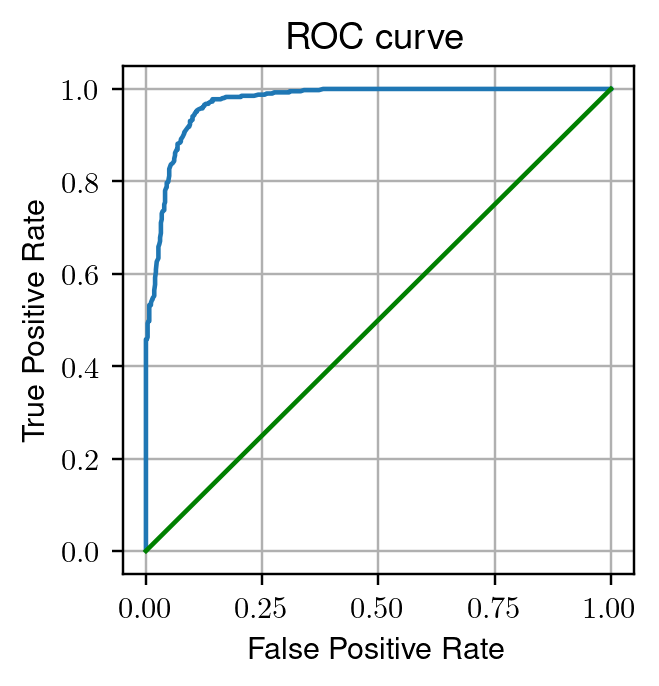

AUC:  0.9718158309569777


In [28]:
filteredDf = pd.read_csv("csv/filteredPresence.csv")
#extract the features
filteredFeaturedDf = extractWindowedFeatures(filteredDf)

#apply labeling based on GT
filteredFeaturedDf["Label"] = filteredFeaturedDf["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label
fpr,tpr = classify_presence(filteredFeaturedDf,ycol="MuStdAmplPaper",plot_roc=True)
print("AUC: ",auc(fpr,tpr))

Example starting from filtered features:

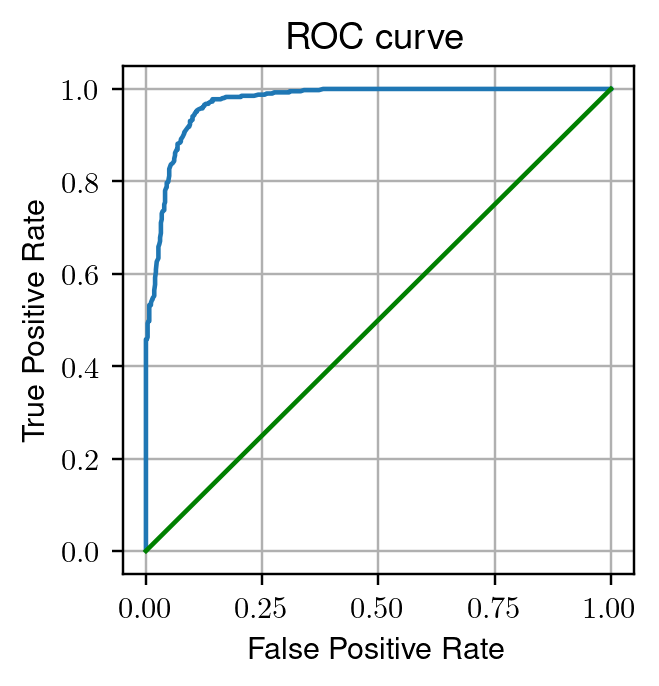

AUC:  0.9718158309569777


In [23]:
filteredFeaturedDf = pd.read_csv("csv/filteredFeaturesPresence3s.csv")
#apply labeling based on GT
filteredFeaturedDf["Label"]= filteredFeaturedDf["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds))
fpr,tpr = classify_presence(filteredFeaturedDf,ycol="MuStdAmplPaper",plot_roc=True)
print("AUC: ",auc(fpr,tpr))